0.0015960175013021167

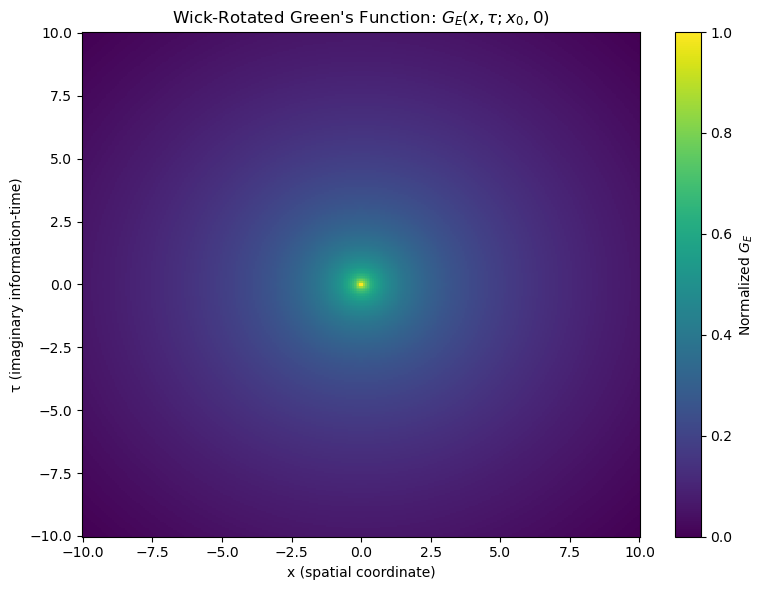

In [2]:
# APPENDIX C.1 Overlay of Real-Time and Imaginary-Time Projections

# Run this First to initialize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Wick-Rotated Green's Function in 1+1D Euclidean space 
# G_E(x, τ; x0, 0) = -(1/4π) * ln[(x - x0)^2 + τ^2]

# === Parameters ===
Nx, Ntau = 300, 300
x_min, x_max = -10, 10
tau_min, tau_max = -10, 10

x0, tau0 = 0.0, 0.0  # Location of CE insertion (origin in info-space)

x = np.linspace(x_min, x_max, Nx)
tau = np.linspace(tau_min, tau_max, Ntau)
X, TAU = np.meshgrid(x, tau)

# Green's function calculation
epsilon = 1e-5  # Regulator to avoid log(0)
GE = -(1 / (4 * np.pi)) * np.log((X - x0)**2 + (TAU - tau0)**2 + epsilon)

# Normalize for visualization
GE_normalized = GE - np.min(GE)
GE_normalized /= np.max(GE_normalized)

# Plot Heatmap
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap("viridis")
norm = mcolors.Normalize(vmin=0, vmax=1)

c = ax.pcolormesh(x, tau, GE_normalized, cmap=cmap, norm=norm, shading='auto')
ax.set_title("Wick-Rotated Green's Function: $G_E(x, \\tau; x_0, 0)$")
ax.set_xlabel("x (spatial coordinate)")
ax.set_ylabel("τ (imaginary information-time)")
fig.colorbar(c, ax=ax, label="Normalized $G_E$")
plt.tight_layout()

# Numerical Validation
# Check symmetry in τ: GE(τ) ≈ GE(-τ) near center
mid_idx = Ntau // 2
symmetry_error = np.abs(GE[mid_idx + 10] - GE[mid_idx - 10]).mean()

#Print symmetry error below:
symmetry_error



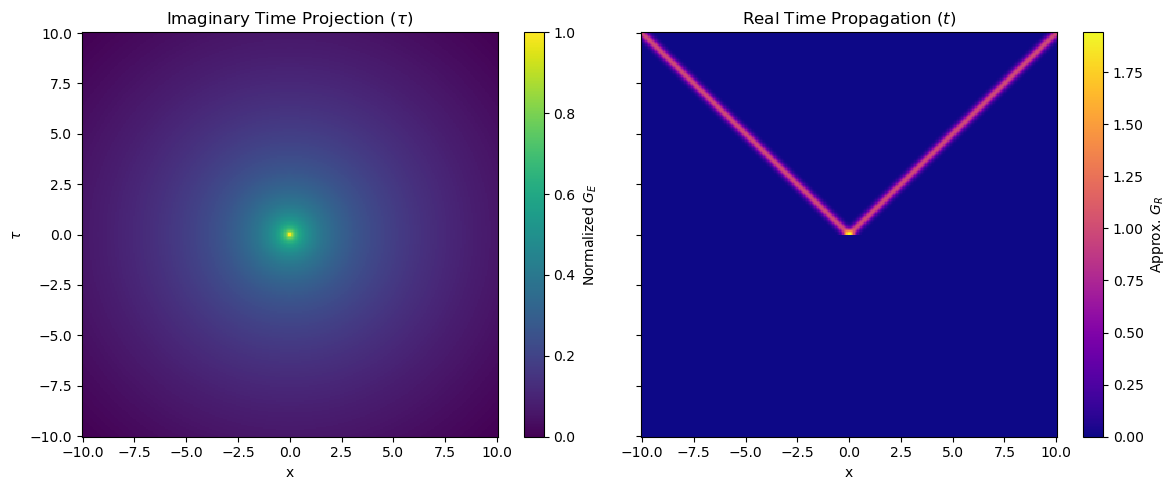

In [4]:
# APPENDIX C.1 cnt'd: Overlay of Real-Time and Imaginary-Time Projections

# Run Second

# Overlay Real-Time vs. Imaginary-Time Projection
# Real-time Green's function (retarded massless scalar in 1+1D):
# G_R(x, t; x0, t0) = (1/2) * θ(t - t0) * [δ(x - x0 - (t - t0)) + δ(x - x0 + (t - t0))]
# We'll approximate the delta functions as narrow Gaussians for visualization.

def gaussian_delta(x, center, width=0.1):
    return np.exp(-((x - center)**2) / (2 * width**2)) / (width * np.sqrt(2 * np.pi))

# Spatial and time grid
t = np.linspace(-10, 10, Ntau)
X_rt, T = np.meshgrid(x, t)

# Retarded Green's function (Gaussian delta approx)
delta1 = gaussian_delta(X_rt, center=(x0 + (T - 0)), width=0.2)
delta2 = gaussian_delta(X_rt, center=(x0 - (T - 0)), width=0.2)
G_rt = 0.5 * (delta1 + delta2)
G_rt[T < 0] = 0  # Apply Heaviside function θ(t - t0)

# Create combined overlay figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Imaginary-time projection (Euclidean)
im1 = ax1.pcolormesh(x, tau, GE_normalized, cmap="viridis", shading='auto')
ax1.set_title("Imaginary Time Projection ($\\tau$)")
ax1.set_xlabel("x")
ax1.set_ylabel("$\\tau$")
fig.colorbar(im1, ax=ax1, label="Normalized $G_E$")

# Real-time projection (Gaussian retarded propagator)
im2 = ax2.pcolormesh(x, t, G_rt, cmap="plasma", shading='auto')
ax2.set_title("Real Time Propagation ($t$)")
ax2.set_xlabel("x")
fig.colorbar(im2, ax=ax2, label="Approx. $G_R$")

plt.tight_layout()
plt.show()


In [8]:
# APPENDIX C.2: Light Cone Slope Extraction in Retarded Green’s Function
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
import pandas as pd

# Define spatial and time grids
Nx = 300
Nt = 300
x = np.linspace(-10, 10, Nx)
t = np.linspace(-10, 10, Nt)
X_rt, T = np.meshgrid(x, t)

# Define Gaussian delta approximation
def gaussian_delta(x, center, width=0.2):
    return np.exp(-((x - center) ** 2) / (2 * width ** 2)) / (width * np.sqrt(2 * np.pi))

# Create Retarded Green's function approximation
x0 = 0  # Center of CE event
delta1 = gaussian_delta(X_rt, center=(x0 + T), width=0.2)
delta2 = gaussian_delta(X_rt, center=(x0 - T), width=0.2)
G_rt = 0.5 * (delta1 + delta2)
G_rt[T < 0] = 0  # Apply Heaviside function θ(t - t0)

# === Smooth for gradient detection ===
G_rt_smooth = gaussian_filter(G_rt, sigma=0.6)

# === Extract slopes from light cone edges ===
slopes = []
for i in range(Nt):
    profile = G_rt_smooth[i, :]
    t_val = t[i]

    peaks, _ = find_peaks(profile, prominence=0.01)

    if len(peaks) >= 2 and abs(t_val) > 1e-6:
        peaks = sorted(peaks)
        x_left, x_right = x[peaks[0]], x[peaks[-1]]

        slope_left = abs((x_left - x0) / t_val)
        slope_right = abs((x_right - x0) / t_val)

        slopes.append((t_val, slope_left, slope_right))

# Convert to DataFrame
slopes = np.array(slopes)
t_vals = slopes[:, 0]
slope_left_vals = slopes[:, 1]
slope_right_vals = slopes[:, 2]

slope_data = pd.DataFrame({
    "Time (t)": t_vals,
    "Left Slope |x_left / t|": slope_left_vals,
    "Right Slope |x_right / t|": slope_right_vals
})

# Display table (for notebook or plotting context)
print(slope_data.head())  # Replace with display(slope_data) if in notebook


   Time (t)  Left Slope |x_left / t|  Right Slope |x_right / t|
0  0.234114                 0.714286                   0.714286
1  0.301003                 1.000000                   1.000000
2  0.367893                 1.000000                   1.000000
3  0.434783                 1.000000                   1.000000
4  0.501672                 1.000000                   1.000000


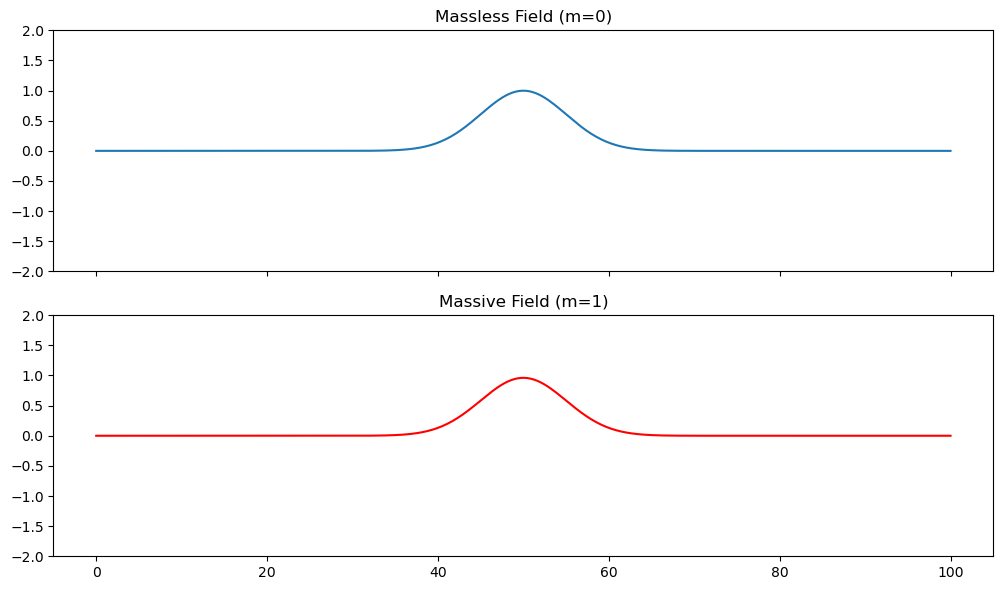

In [40]:
#C.3 Massless vs. Massive Scalar Field Evolution with Collapse Emergence Insertion

# C.3 (i)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#  Simulation Parameters 
L = 100.0
Nx = 512
dx = L / Nx
x = np.linspace(0, L, Nx)

T = 100.0
dt = 0.05
Nt = int(T / dt)

c = 1.0
lambda_CE = 2.0
t0 = 50.0

mass_massless = 0.0   # Massless field
mass_massive = 1.0    # Compare with massive field

# Initial Field 
def initial_condition():
    return np.exp(-0.5 * ((x - L/2) / 5)**2)

# Second spatial derivative
def laplacian(field):
    return (np.roll(field, -1) - 2 * field + np.roll(field, 1)) / dx**2

#  Prepare storage 
fields_massless = []
fields_massive = []
times = []

#  Initialize both systems 
A0 = initial_condition()
A_massless = A0.copy()
A_massless_prev = A0.copy()
A_massive = A0.copy()
A_massive_prev = A0.copy()

#  Time Evolution 
for n in range(1, Nt + 1):
    t = n * dt

    # Massless update
    A_massless_next = (2 * A_massless - A_massless_prev +
                      (c * dt)**2 * laplacian(A_massless))

    # Massive update
    A_massive_next = (2 * A_massive - A_massive_prev +
                     (c * dt)**2 * (laplacian(A_massive) - mass_massive**2 * A_massive))

    # CE insertion at t = t0
    if np.isclose(t, t0, atol=0.5 * dt):
        A_massless_next += dt**2 * (lambda_CE / 6.0) * A_massless**3
        A_massive_next  += dt**2 * (lambda_CE / 6.0) * A_massive**3

    # Step forward in time
    A_massless_prev[:] = A_massless
    A_massless[:] = A_massless_next
    A_massive_prev[:] = A_massive
    A_massive[:] = A_massive_next

    if n % 5 == 0:
        times.append(t)
        fields_massless.append(A_massless.copy())
        fields_massive.append(A_massive.copy())

#  Animation 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
line1, = ax1.plot(x, fields_massless[0], label="Massless")
line2, = ax2.plot(x, fields_massive[0], label="Massive", color='r')

ax1.set_ylim(-2, 2)
ax2.set_ylim(-2, 2)
ax1.set_title("Massless Field (m=0)")
ax2.set_title("Massive Field (m=1)")

def update(frame):
    line1.set_ydata(fields_massless[frame])
    line2.set_ydata(fields_massive[frame])
    ax1.set_title(f"Massless Field | t = {times[frame]:.2f}")
    ax2.set_title(f"Massive Field | t = {times[frame]:.2f}")
    return line1, line2

ani = animation.FuncAnimation(fig, update, frames=len(times), interval=30)
plt.tight_layout()
plt.show()



/opt/anaconda3/lib/python3.12/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


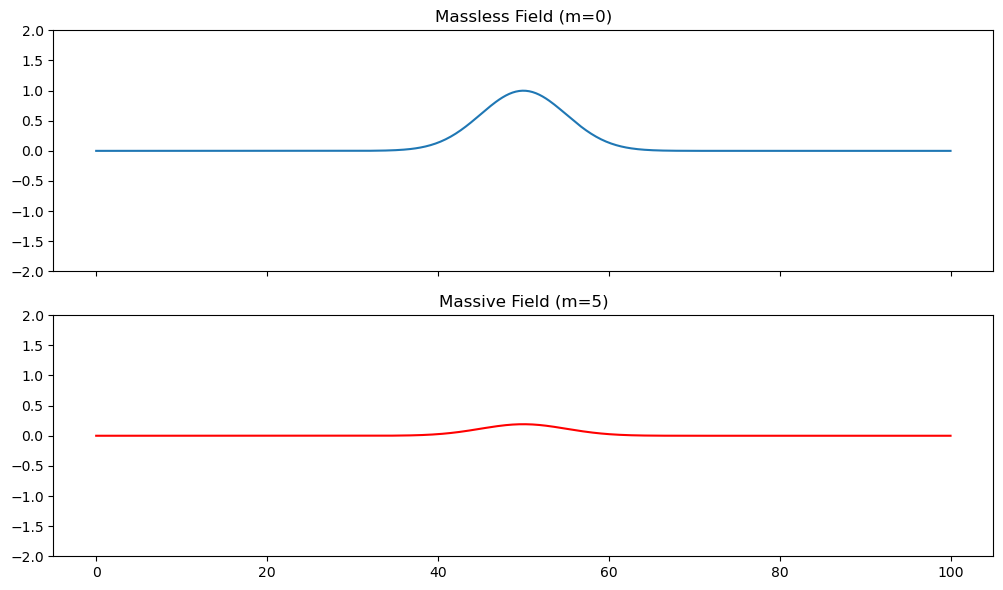

In [34]:
#C.3 Massless vs. Massive Scalar Field Evolution with Collapse Emergence Insertion

# Massless vs Mass iteration: (ii)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#  Simulation Parameters 
L = 100.0
Nx = 512
dx = L / Nx
x = np.linspace(0, L, Nx)

T = 100.0
dt = 0.05
Nt = int(T / dt)

c = 1.0
lambda_CE = 2.0
t0 = 50.0

mass_massless = 0.0   # Massless field
mass_massive = 5.0    # Compare with massive field

# Initial Field 
def initial_condition():
    return np.exp(-0.5 * ((x - L/2) / 5)**2)

# Second spatial derivative
def laplacian(field):
    return (np.roll(field, -1) - 2 * field + np.roll(field, 1)) / dx**2

#  Prepare storage 
fields_massless = []
fields_massive = []
times = []

#  Initialize both systems 
A0 = initial_condition()
A_massless = A0.copy()
A_massless_prev = A0.copy()
A_massive = A0.copy()
A_massive_prev = A0.copy()

#  Time Evolution 
for n in range(1, Nt + 1):
    t = n * dt

    # Massless update
    A_massless_next = (2 * A_massless - A_massless_prev +
                      (c * dt)**2 * laplacian(A_massless))

    # Massive update
    A_massive_next = (2 * A_massive - A_massive_prev +
                     (c * dt)**2 * (laplacian(A_massive) - mass_massive**2 * A_massive))

    # CE insertion at t = t0
    if np.isclose(t, t0, atol=0.5 * dt):
        A_massless_next += dt**2 * (lambda_CE / 6.0) * A_massless**3
        A_massive_next  += dt**2 * (lambda_CE / 6.0) * A_massive**3

    # Step forward in time
    A_massless_prev[:] = A_massless
    A_massless[:] = A_massless_next
    A_massive_prev[:] = A_massive
    A_massive[:] = A_massive_next

    if n % 5 == 0:
        times.append(t)
        fields_massless.append(A_massless.copy())
        fields_massive.append(A_massive.copy())

#  Animation 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
line1, = ax1.plot(x, fields_massless[0], label="Massless")
line2, = ax2.plot(x, fields_massive[0], label="Massive", color='r')

ax1.set_ylim(-2, 2)
ax2.set_ylim(-2, 2)
ax1.set_title("Massless Field (m=0)")
ax2.set_title("Massive Field (m=5)")

def update(frame):
    line1.set_ydata(fields_massless[frame])
    line2.set_ydata(fields_massive[frame])
    ax1.set_title(f"Massless Field | t = {times[frame]:.2f}")
    ax2.set_title(f"Massive Field | t = {times[frame]:.2f}")
    return line1, line2

ani = animation.FuncAnimation(fig, update, frames=len(times), interval=30)
plt.tight_layout()
plt.show()



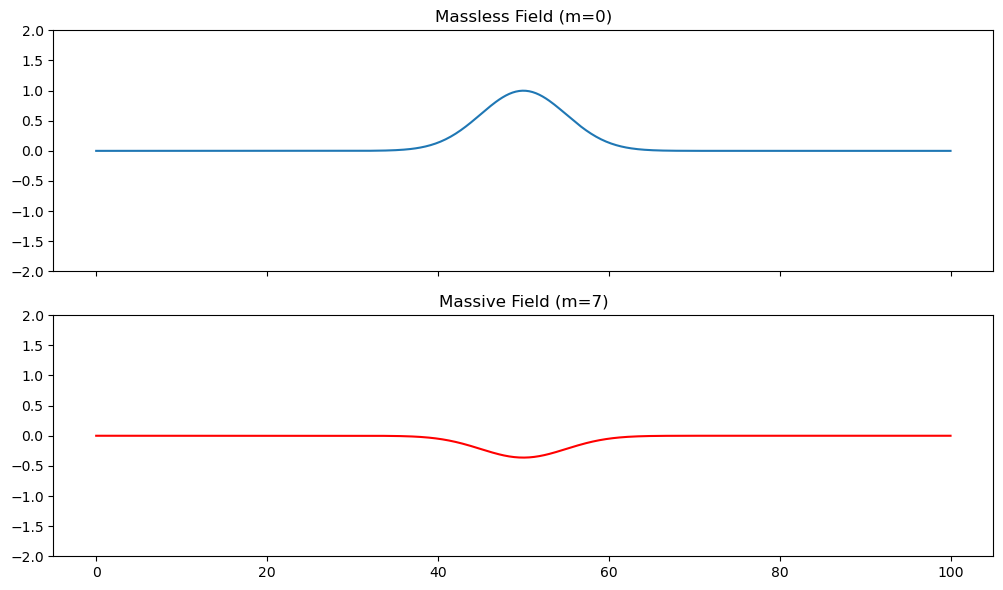

In [35]:
#C.3 Massless vs. Massive Scalar Field Evolution with Collapse Emergence Insertion

# Massless vs Mass iteration: (iii)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#  Simulation Parameters 
L = 100.0
Nx = 512
dx = L / Nx
x = np.linspace(0, L, Nx)

T = 100.0
dt = 0.05
Nt = int(T / dt)

c = 1.0
lambda_CE = 2.0
t0 = 50.0

mass_massless = 0.0   # Massless field
mass_massive = 7.0    # Compare with massive field

# Initial Field 
def initial_condition():
    return np.exp(-0.5 * ((x - L/2) / 5)**2)

# Second spatial derivative
def laplacian(field):
    return (np.roll(field, -1) - 2 * field + np.roll(field, 1)) / dx**2

#  Prepare storage 
fields_massless = []
fields_massive = []
times = []

#  Initialize both systems 
A0 = initial_condition()
A_massless = A0.copy()
A_massless_prev = A0.copy()
A_massive = A0.copy()
A_massive_prev = A0.copy()

#  Time Evolution 
for n in range(1, Nt + 1):
    t = n * dt

    # Massless update
    A_massless_next = (2 * A_massless - A_massless_prev +
                      (c * dt)**2 * laplacian(A_massless))

    # Massive update
    A_massive_next = (2 * A_massive - A_massive_prev +
                     (c * dt)**2 * (laplacian(A_massive) - mass_massive**2 * A_massive))

    # CE insertion at t = t0
    if np.isclose(t, t0, atol=0.5 * dt):
        A_massless_next += dt**2 * (lambda_CE / 6.0) * A_massless**3
        A_massive_next  += dt**2 * (lambda_CE / 6.0) * A_massive**3

    # Step forward in time
    A_massless_prev[:] = A_massless
    A_massless[:] = A_massless_next
    A_massive_prev[:] = A_massive
    A_massive[:] = A_massive_next

    if n % 5 == 0:
        times.append(t)
        fields_massless.append(A_massless.copy())
        fields_massive.append(A_massive.copy())

#  Animation 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
line1, = ax1.plot(x, fields_massless[0], label="Massless")
line2, = ax2.plot(x, fields_massive[0], label="Massive", color='r')

ax1.set_ylim(-2, 2)
ax2.set_ylim(-2, 2)
ax1.set_title("Massless Field (m=0)")
ax2.set_title("Massive Field (m=7)")

def update(frame):
    line1.set_ydata(fields_massless[frame])
    line2.set_ydata(fields_massive[frame])
    ax1.set_title(f"Massless Field | t = {times[frame]:.2f}")
    ax2.set_title(f"Massive Field | t = {times[frame]:.2f}")
    return line1, line2

ani = animation.FuncAnimation(fig, update, frames=len(times), interval=30)
plt.tight_layout()
plt.show()



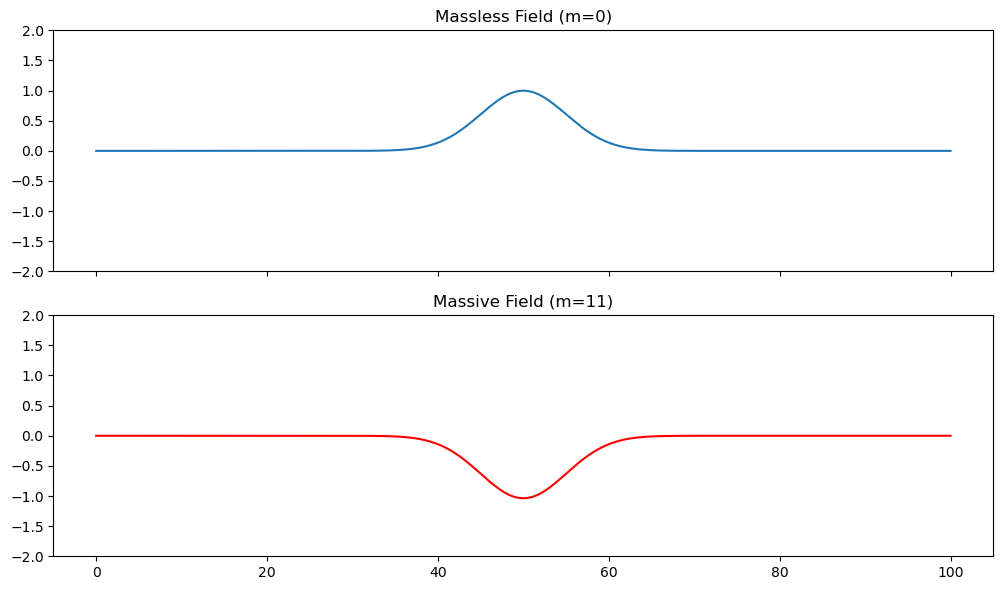

In [36]:
#C.3 
# Massless vs Mass iteration: (iv)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#  Simulation Parameters 
L = 100.0
Nx = 512
dx = L / Nx
x = np.linspace(0, L, Nx)

T = 100.0
dt = 0.05
Nt = int(T / dt)

c = 1.0
lambda_CE = 2.0
t0 = 50.0

mass_massless = 0.0   # Massless field
mass_massive = 11.0    # Compare with massive field

#  Initial Field 
def initial_condition():
    return np.exp(-0.5 * ((x - L/2) / 5)**2)

#  Second spatial derivative
def laplacian(field):
    return (np.roll(field, -1) - 2 * field + np.roll(field, 1)) / dx**2

#  Prepare storage 
fields_massless = []
fields_massive = []
times = []

#  Initialize both systems 
A0 = initial_condition()
A_massless = A0.copy()
A_massless_prev = A0.copy()
A_massive = A0.copy()
A_massive_prev = A0.copy()

#  Time Evolution 
for n in range(1, Nt + 1):
    t = n * dt

    # Massless update
    A_massless_next = (2 * A_massless - A_massless_prev +
                      (c * dt)**2 * laplacian(A_massless))

    # Massive update
    A_massive_next = (2 * A_massive - A_massive_prev +
                     (c * dt)**2 * (laplacian(A_massive) - mass_massive**2 * A_massive))

    # CE insertion at t = t0
    if np.isclose(t, t0, atol=0.5 * dt):
        A_massless_next += dt**2 * (lambda_CE / 6.0) * A_massless**3
        A_massive_next  += dt**2 * (lambda_CE / 6.0) * A_massive**3

    # Step forward in time
    A_massless_prev[:] = A_massless
    A_massless[:] = A_massless_next
    A_massive_prev[:] = A_massive
    A_massive[:] = A_massive_next

    if n % 5 == 0:
        times.append(t)
        fields_massless.append(A_massless.copy())
        fields_massive.append(A_massive.copy())

#  Animation 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
line1, = ax1.plot(x, fields_massless[0], label="Massless")
line2, = ax2.plot(x, fields_massive[0], label="Massive", color='r')

ax1.set_ylim(-2, 2)
ax2.set_ylim(-2, 2)
ax1.set_title("Massless Field (m=0)")
ax2.set_title("Massive Field (m=11)")

def update(frame):
    line1.set_ydata(fields_massless[frame])
    line2.set_ydata(fields_massive[frame])
    ax1.set_title(f"Massless Field | t = {times[frame]:.2f}")
    ax2.set_title(f"Massive Field | t = {times[frame]:.2f}")
    return line1, line2

plt.tight_layout()
plt.show()


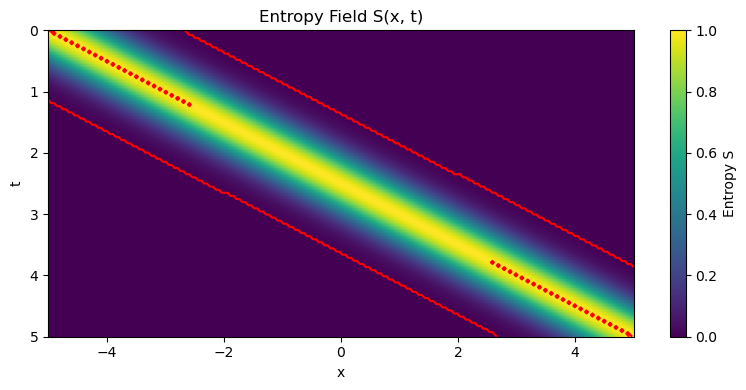

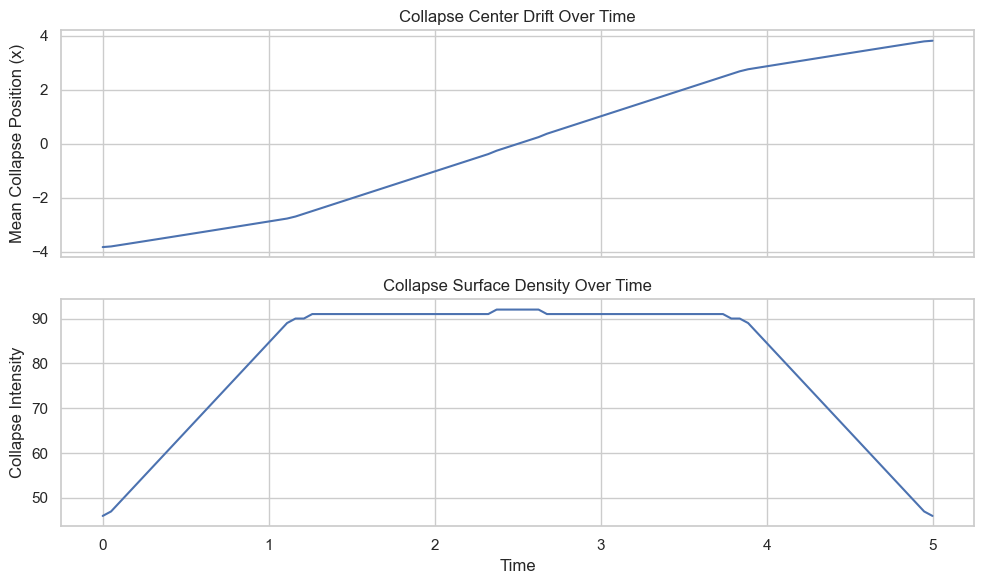


Collapse Surface Statistical Analysis:

 Slope (collapse drift)  Intercept  R-squared       p-value  Standard error  Mean collapse position  Std. dev of collapse position  Mean collapse intensity  Std. dev of collapse intensity
               1.732143  -4.330357   0.990804 1.330119e-101        0.016857            1.776357e-16                       2.549733                     80.0                       15.015144


In [43]:
#C.4 Numerical Demonstration of Directional Collapse Asymmetry in the CE Framework
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#  CONFIGURATION 
Nx, Nt = 200, 100           # Grid points in space and time
Lx, T = 10.0, 5.0           # Spatial and temporal extent
x = np.linspace(-Lx/2, Lx/2, Nx)
t = np.linspace(0, T, Nt)
X, T_grid = np.meshgrid(x, t)

#  ENTROPY FIELD: Gaussian entropy gradient drifting in time 
def entropy_field(x, t):
    return np.exp(-(x - 2 * (t - T/2))**2)

S = np.array([[entropy_field(xi, ti) for xi in x] for ti in t])

#  COLLAPSE SURFACES 
dS_dt = np.gradient(S, t, axis=0)
collapse_mask = np.abs(dS_dt) > 0.05  # Collapse threshold

#  PLOT 1: ENTROPY FIELD WITH COLLAPSE SURFACE ]
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(S, extent=[x.min(), x.max(), t.max(), t.min()],
               aspect='auto', cmap='viridis')
ax.set_title("Entropy Field S(x, t)")
ax.set_xlabel("x")
ax.set_ylabel("t")
cbar = plt.colorbar(im, ax=ax, label='Entropy S')
ax.contour(X, T_grid, collapse_mask, levels=[0.5], colors='red', linewidths=1.5)
plt.tight_layout()
plt.show()

#  NUMERICAL VALIDATION: Collapse Drift and Intensity 
collapse_positions = np.where(collapse_mask, X, np.nan)
mean_collapse_position = np.nanmean(collapse_positions, axis=1)
collapse_intensity = np.sum(collapse_mask, axis=1)

df = pd.DataFrame({
    "time": t,
    "mean_collapse_x": mean_collapse_position,
    "collapse_intensity": collapse_intensity
}).dropna()

# === PLOT 2: Drift and Intensity ===
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

sns.lineplot(data=df, x="time", y="mean_collapse_x", ax=axs[0])
axs[0].set_ylabel("Mean Collapse Position (x)")
axs[0].set_title("Collapse Center Drift Over Time")

sns.lineplot(data=df, x="time", y="collapse_intensity", ax=axs[1])
axs[1].set_ylabel("Collapse Intensity")
axs[1].set_xlabel("Time")
axs[1].set_title("Collapse Surface Density Over Time")

plt.tight_layout()
plt.show()

from scipy.stats import linregress


#  STATISTICAL ANALYSIS 
# Linear regression on collapse center drift to assess directional bias
slope, intercept, r_value, p_value, std_err = linregress(df["time"], df["mean_collapse_x"])

# Report results
stats_results = {
    "Slope (collapse drift)": slope,
    "Intercept": intercept,
    "R-squared": r_value**2,
    "p-value": p_value,
    "Standard error": std_err,
    "Mean collapse position": df["mean_collapse_x"].mean(),
    "Std. dev of collapse position": df["mean_collapse_x"].std(),
    "Mean collapse intensity": df["collapse_intensity"].mean(),
    "Std. dev of collapse intensity": df["collapse_intensity"].std(),
}

import pandas as pd
#  PRINT RESULTS LOCALLY 
stats_df = pd.DataFrame([stats_results])
print("\nCollapse Surface Statistical Analysis:\n")
print(stats_df.to_string(index=False))




 Original (All Nonlinearities) 


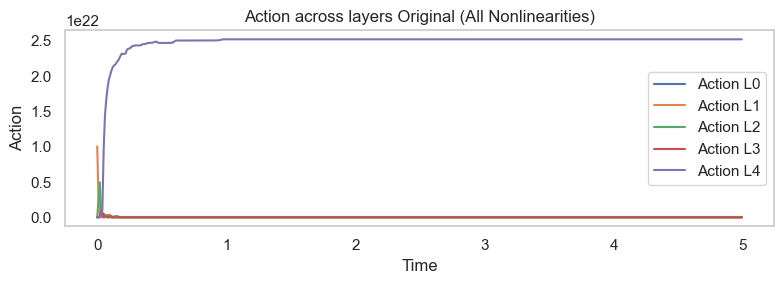

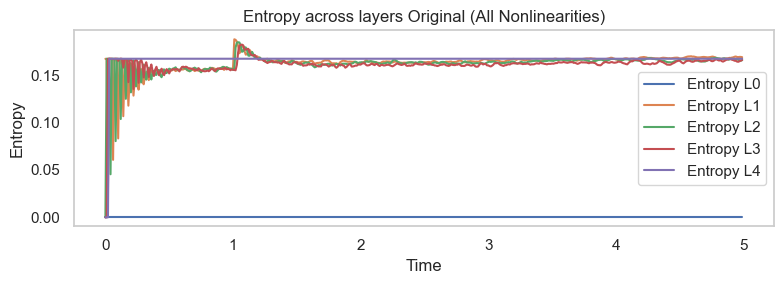

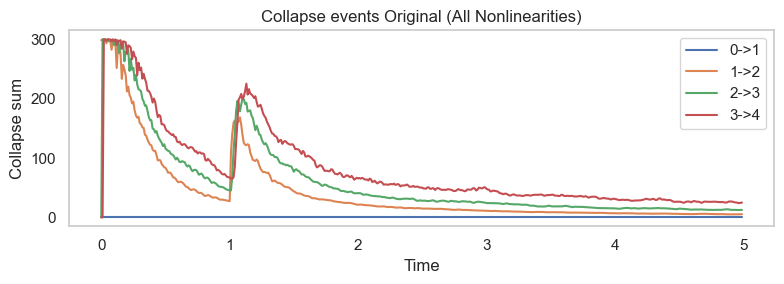

 Action Summary 
       count          mean           std        min           25%  \
S_n+0  500.0  1.000000e+01  0.000000e+00  10.000000  1.000000e+01   
S_n+1  500.0  3.055603e+19  4.660838e+20   1.383453  9.947130e+00   
S_n+2  500.0  2.001172e+19  2.506082e+20   2.715886  9.920602e+00   
S_n+3  500.0  4.932607e+18  5.344346e+19   3.439759  9.868495e+00   
S_n+4  500.0  2.474417e+22  2.711663e+21  10.000000  2.523223e+22   

                50%           75%           max  
S_n+0  1.000000e+01  1.000000e+01  1.000000e+01  
S_n+1  1.000855e+01  1.009413e+01  1.005752e+22  
S_n+2  1.000653e+01  1.012667e+01  4.962619e+21  
S_n+3  1.002169e+01  1.019639e+01  8.657123e+20  
S_n+4  2.523223e+22  2.523223e+22  2.523223e+22  

 Collapse Summary 
      count       mean        std       min        25%        50%         75%  \
0->1  500.0   0.000000   0.000000  0.000000   0.000000   0.000000    0.000000   
1->2  500.0  42.758926  64.033601  5.003764   7.770350  14.949390   43.019933   
2->3 

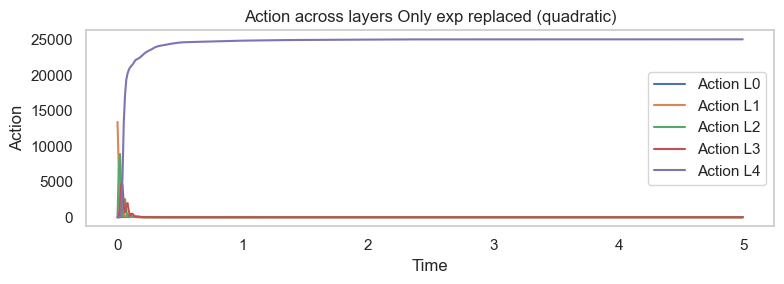

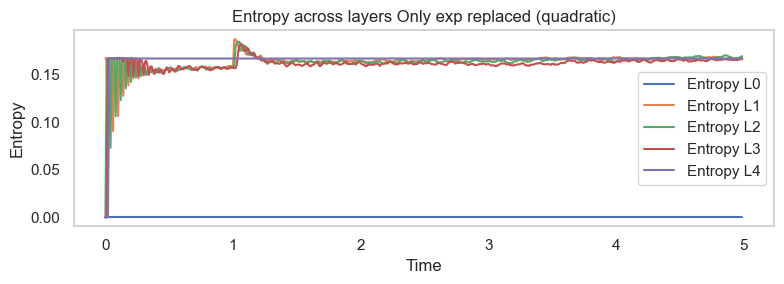

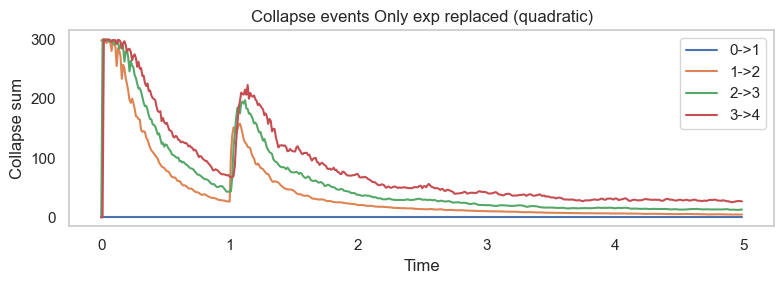

 Action Summary 
       count          mean          std       min           25%           50%  \
S_n+0  500.0      0.000000     0.000000  0.000000      0.000000      0.000000   
S_n+1  500.0     51.167439   680.015879 -8.596238     -0.031853      0.001820   
S_n+2  500.0     53.916122   551.994621 -7.405280     -0.073751      0.010432   
S_n+3  500.0     40.530513   338.283156 -6.364687     -0.098085      0.032074   
S_n+4  500.0  24609.261368  2519.846364  0.000000  24964.481258  25084.186564   

                75%           max  
S_n+0      0.000000      0.000000  
S_n+1      0.043624  13440.633931  
S_n+2      0.117785   8922.102796  
S_n+3      0.228526   4739.666704  
S_n+4  25091.397238  25096.597198  

 Collapse Summary 
      count       mean        std       min        25%        50%         75%  \
0->1  500.0   0.000000   0.000000  0.000000   0.000000   0.000000    0.000000   
1->2  500.0  41.893858  63.621243  4.743279   7.000999  14.016225   42.625538   
2->3  500.0  60.6

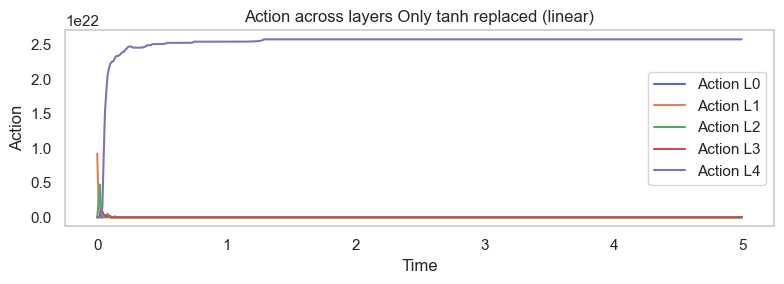

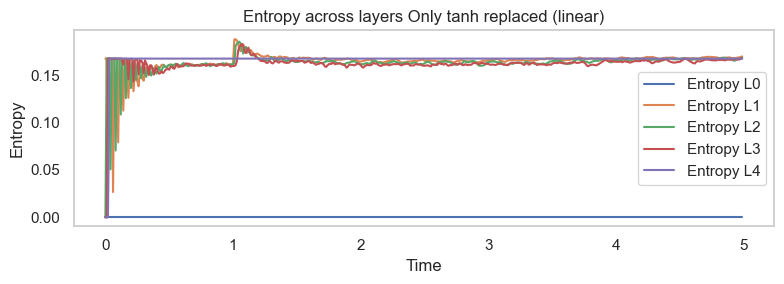

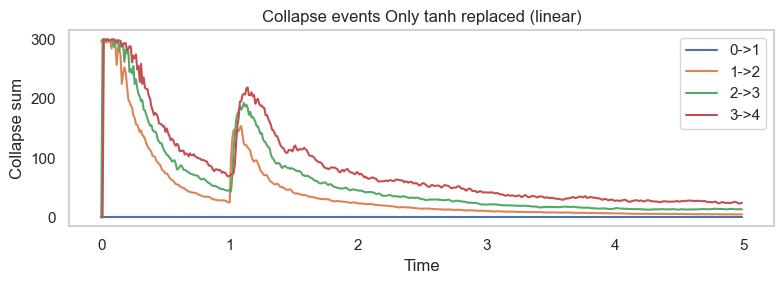

 Action Summary 
       count          mean           std         min           25%  \
S_n+0  500.0  1.000000e+01  0.000000e+00   10.000000  1.000000e+01   
S_n+1  500.0  2.526896e+19  4.255180e+20 -142.185463  9.974529e+00   
S_n+2  500.0  1.660856e+19  2.340059e+20 -395.275002  9.887061e+00   
S_n+3  500.0  6.473832e+18  6.139636e+19 -613.118856  9.796914e+00   
S_n+4  500.0  2.522797e+22  2.731702e+21   10.000000  2.548142e+22   

                50%           75%           max  
S_n+0  1.000000e+01  1.000000e+01  1.000000e+01  
S_n+1  1.000206e+01  1.004714e+01  9.231887e+21  
S_n+2  1.001697e+01  1.013582e+01  4.737606e+21  
S_n+3  1.000925e+01  1.031463e+01  8.718618e+20  
S_n+4  2.575070e+22  2.575070e+22  2.575070e+22  

 Collapse Summary 
      count       mean        std       min        25%        50%         75%  \
0->1  500.0   0.000000   0.000000  0.000000   0.000000   0.000000    0.000000   
1->2  500.0  41.169179  62.306862  4.983129   7.569197  14.812183   40.423614   

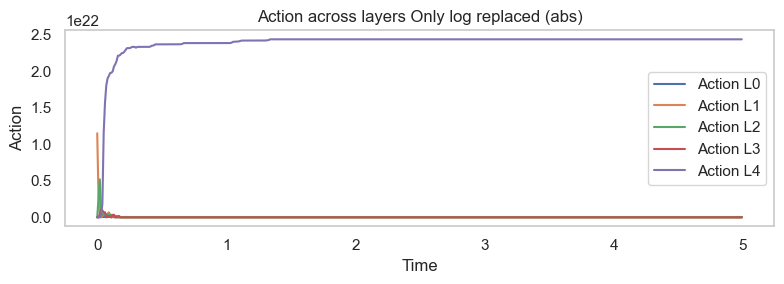

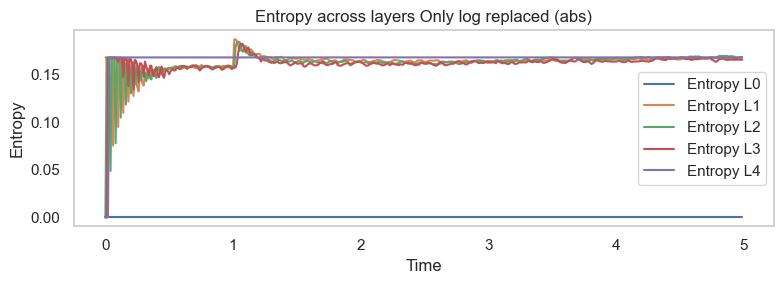

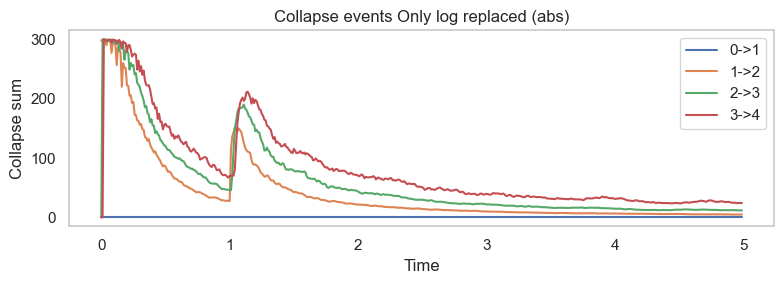

 Action Summary 
       count          mean           std        min           25%  \
S_n+0  500.0  1.000000e+01  0.000000e+00  10.000000  1.000000e+01   
S_n+1  500.0  3.537982e+19  5.305622e+20   1.661297  9.963015e+00   
S_n+2  500.0  2.370536e+19  2.649057e+20   3.502748  9.950220e+00   
S_n+3  500.0  1.070755e+19  8.343289e+19   4.352252  9.857571e+00   
S_n+4  500.0  2.385107e+22  2.548429e+21  10.000000  2.419730e+22   

                50%           75%           max  
S_n+0  1.000000e+01  1.000000e+01  1.000000e+01  
S_n+1  1.001021e+01  1.007662e+01  1.150122e+22  
S_n+2  1.001384e+01  1.015004e+01  5.198715e+21  
S_n+3  1.003709e+01  1.023033e+01  1.061643e+21  
S_n+4  2.436812e+22  2.436812e+22  2.436812e+22  

 Collapse Summary 
      count       mean        std       min        25%        50%         75%  \
0->1  500.0   0.000000   0.000000  0.000000   0.000000   0.000000    0.000000   
1->2  500.0  41.700922  63.561603  4.624796   6.903812  14.158382   42.518702   
2->3 

In [49]:
# C.5 Action Principle-Based Multi-Layer Collapse Emergence Simulation
# i.e., UNIQUE LAGRANGIAN STRESS TEST 
# Note: This script generates multiple runs 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Original Simulation Class 

class CollapseEmergenceSimulation:
    def __init__(self, L=10.0, Nx=300, Nt=500, dt=0.01, num_layers=5,
                 lambda1=1.0, lambda2=1.0, lambda3=1.0,
                 kappa1=2.0, kappa2=2.0, c=1.0,
                 collapse_gain=5.0, decay_rate=0.01,
                 t0_layer=1, t0_time=100):
        self.L, self.Nx, self.Nt, self.dt = L, Nx, Nt, dt
        self.dx = L / Nx
        self.x = np.linspace(0, L, Nx)
        self.num_layers = num_layers
        self.fields = [np.zeros_like(self.x) for _ in range(num_layers)]
        self.fields[t0_layer] = np.exp(-0.5*(self.x - L/2)**2) + 0.05*np.random.randn(Nx)
        self.prev = [f.copy() for f in self.fields]
        self.next = [np.zeros_like(self.x) for _ in range(num_layers)]
        self.lambda1, self.lambda2, self.lambda3 = lambda1, lambda2, lambda3
        self.kappa1, self.kappa2, self.c = kappa1, kappa2, c
        self.collapse_gain = collapse_gain
        self.decay_rate = decay_rate
        self.t0_layer = t0_layer
        self.t0_time = t0_time
        self.history = {
            'fields':   [[] for _ in range(num_layers)],
            'action':   [[] for _ in range(num_layers)],
            'entropy':  [[] for _ in range(num_layers)],
            'collapse': [[] for _ in range(num_layers-1)]
        }
    
    def _compute_entropy(self, field):
        p = np.abs(field)
        p /= (p.sum() + 1e-12)
        return -np.sum(p * np.log(p + 1e-12)) * self.dx
    
    def _compute_action(self, field, prev):
        grad_x = np.gradient(field, self.dx)
        d_t = (field - prev) / self.dt
        d2x = np.gradient(np.gradient(field, self.dx), self.dx)
        d2t = (field - 2*prev + field) / self.dt**2
        arg1 = np.clip(self.kappa1 * d2x, -50, 50)
        term1 = self.lambda1 * np.exp(arg1)
        term2 = -self.lambda2 * np.tanh(self.kappa2 * (d2x - d2t/self.c**2))
        term3 = self.lambda3 * np.log(1 + grad_x**2)
        lag = term1 + term2 + term3
        return np.sum(lag) * self.dx
    
    def run(self):
        for t in range(self.Nt):
            for i in range(self.num_layers):
                self.next[i] = 2*self.fields[i] - self.prev[i]
            if t == self.t0_time:
                i = self.t0_layer
                d2x = np.gradient(np.gradient(self.fields[i], self.dx), self.dx)
                d2t = (self.fields[i] - 2*self.prev[i] + self.next[i]) / self.dt**2
                arg1 = np.clip(self.kappa1 * d2x, -50, 50)
                term1 = self.lambda1 * np.exp(arg1)
                term2 = -self.lambda2 * np.tanh(self.kappa2 * (d2x - d2t/self.c**2))
                term3 = self.lambda3 * np.log(1 + np.gradient(self.fields[i], self.dx)**2)
                F_CE = term1 + term2 - term3
                self.next[i] += self.dt**2 * F_CE
            for i in range(self.num_layers-1):
                grad_x = np.gradient(self.fields[i], self.dx)
                d_t = (self.fields[i] - self.prev[i]) / self.dt
                curvature = (self.lambda1*np.gradient(grad_x, self.dx)
                             + self.lambda2*self.fields[i]
                             - self.kappa2*np.gradient(d_t, self.dx))
                cE = np.tanh(self.collapse_gain * np.abs(curvature))
                self.next[i+1] += 0.5 * cE * self.fields[i]
                self.next[i] *= (1 - 0.5 * cE)
                self.history['collapse'][i].append(np.sum(cE))
            for i in range(self.num_layers):
                ent = self._compute_entropy(self.fields[i])
                act = self._compute_action(self.fields[i], self.prev[i])
                self.history['entropy'][i].append(ent)
                self.history['action'][i].append(act)
                self.history['fields'][i].append(self.fields[i].copy())
                self.prev[i] = self.fields[i].copy()
                self.fields[i] = self.next[i].copy()
        return self.history
    
    def plot_summary(self, label=""):
        t_axis = np.arange(self.Nt) * self.dt
        plt.figure(figsize=(8,3))
        for i in range(self.num_layers):
            plt.plot(t_axis, self.history['action'][i], label=f"Action L{i}")
        plt.title(f"Action across layers {label}"); plt.xlabel("Time"); plt.ylabel("Action")
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()
        
        plt.figure(figsize=(8,3))
        for i in range(self.num_layers):
            plt.plot(t_axis, self.history['entropy'][i], label=f"Entropy L{i}")
        plt.title(f"Entropy across layers {label}"); plt.xlabel("Time"); plt.ylabel("Entropy")
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()
        
        plt.figure(figsize=(8,3))
        for i, coll in enumerate(self.history['collapse']):
            plt.plot(t_axis[:len(coll)], coll, label=f"{i}->{i+1}")
        plt.title(f"Collapse events {label}"); plt.xlabel("Time"); plt.ylabel("Collapse sum")
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

#  2. Variant classes 

class CEExpPoly(CollapseEmergenceSimulation):
    """Only exp replaced with quadratic, other terms original."""
    def _compute_action(self, field, prev):
        grad_x = np.gradient(field, self.dx)
        d2x = np.gradient(np.gradient(field, self.dx), self.dx)
        d2t = (field - 2*prev + field) / self.dt**2
        arg1 = np.clip(self.kappa1 * d2x, -50, 50)
        term1 = self.lambda1 * arg1**2
        term2 = -self.lambda2 * np.tanh(self.kappa2 * (d2x - d2t/self.c**2))
        term3 = self.lambda3 * np.log(1 + grad_x**2)
        lag = term1 + term2 + term3
        return np.sum(lag) * self.dx

class CETanhLinear(CollapseEmergenceSimulation):
    """Only tanh replaced with linear, other terms original."""
    def _compute_action(self, field, prev):
        grad_x = np.gradient(field, self.dx)
        d2x = np.gradient(np.gradient(field, self.dx), self.dx)
        d2t = (field - 2*prev + field) / self.dt**2
        arg1 = np.clip(self.kappa1 * d2x, -50, 50)
        term1 = self.lambda1 * np.exp(arg1)
        term2 = -self.lambda2 * (self.kappa2 * (d2x - d2t/self.c**2))
        term3 = self.lambda3 * np.log(1 + grad_x**2)
        lag = term1 + term2 + term3
        return np.sum(lag) * self.dx

class CELogAbs(CollapseEmergenceSimulation):
    """Only log replaced with abs, other terms original."""
    def _compute_action(self, field, prev):
        grad_x = np.gradient(field, self.dx)
        d2x = np.gradient(np.gradient(field, self.dx), self.dx)
        d2t = (field - 2*prev + field) / self.dt**2
        arg1 = np.clip(self.kappa1 * d2x, -50, 50)
        term1 = self.lambda1 * np.exp(arg1)
        term2 = -self.lambda2 * np.tanh(self.kappa2 * (d2x - d2t/self.c**2))
        term3 = self.lambda3 * np.abs(grad_x)
        lag = term1 + term2 + term3
        return np.sum(lag) * self.dx

#  3. Run all variants 

def run_and_report(SimClass, label):
    print(f"\n\n {label} ")
    sim = SimClass()
    history = sim.run()
    sim.plot_summary(label=label)
    action_df = pd.DataFrame({f"S_n+{i}": history['action'][i] for i in range(sim.num_layers)})
    collapse_df = pd.DataFrame({f"{i}->{i+1}": history['collapse'][i] for i in range(sim.num_layers-1)})
    entropy_df = pd.DataFrame({f"S_n+{i}": history['entropy'][i] for i in range(sim.num_layers)})
    print(" Action Summary ")
    print(action_df.describe().T)
    print("\n Collapse Summary ")
    print(collapse_df.describe().T)
    print("\n Entropy Summary ")
    print(entropy_df.describe().T)

#  4. Actually run them all 

run_and_report(CollapseEmergenceSimulation, "Original (All Nonlinearities)")
run_and_report(CEExpPoly, "Only exp replaced (quadratic)")
run_and_report(CETanhLinear, "Only tanh replaced (linear)")
run_and_report(CELogAbs, "Only log replaced (abs)")


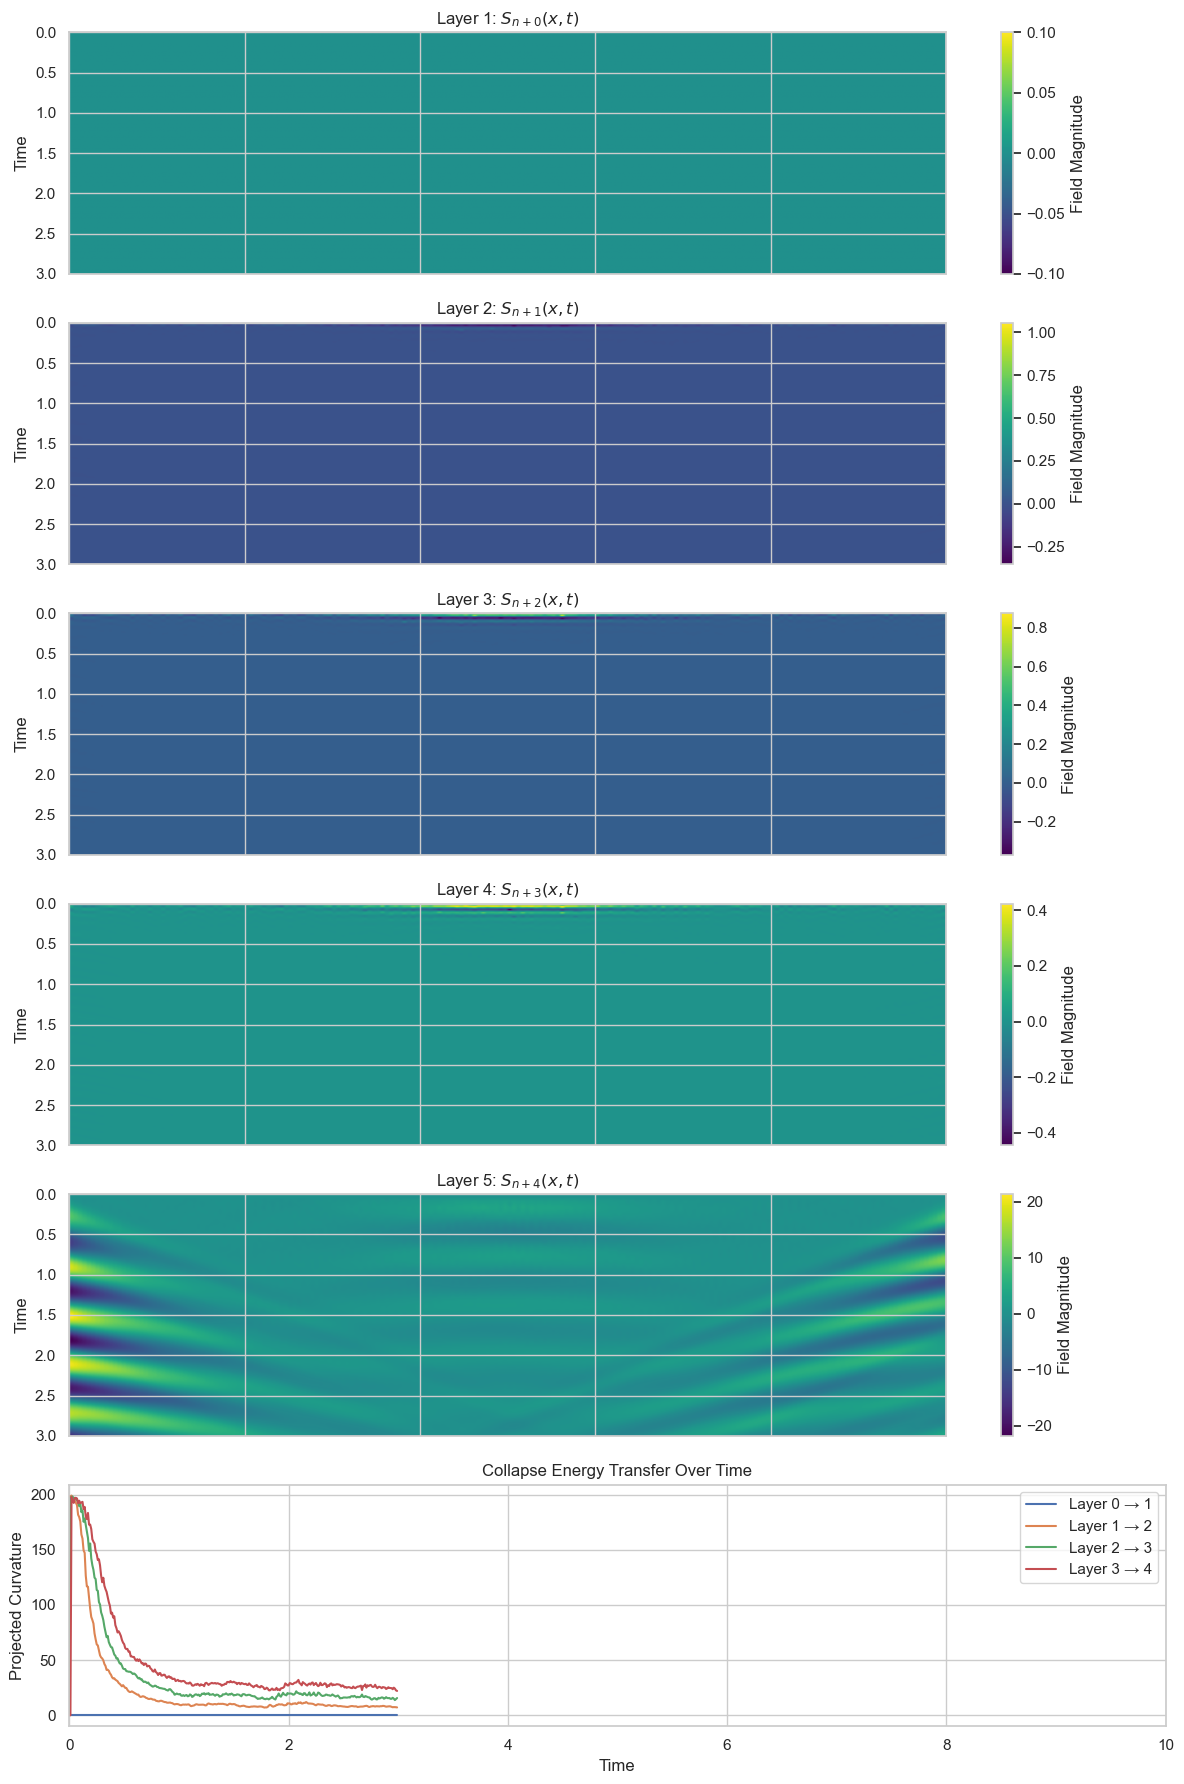

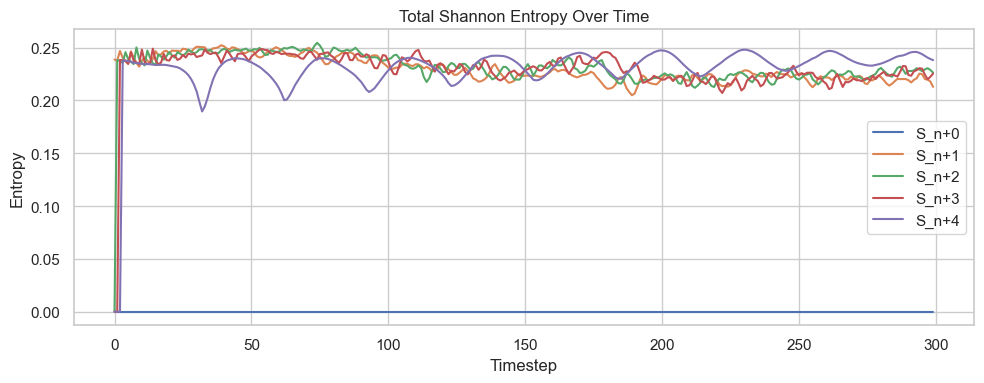

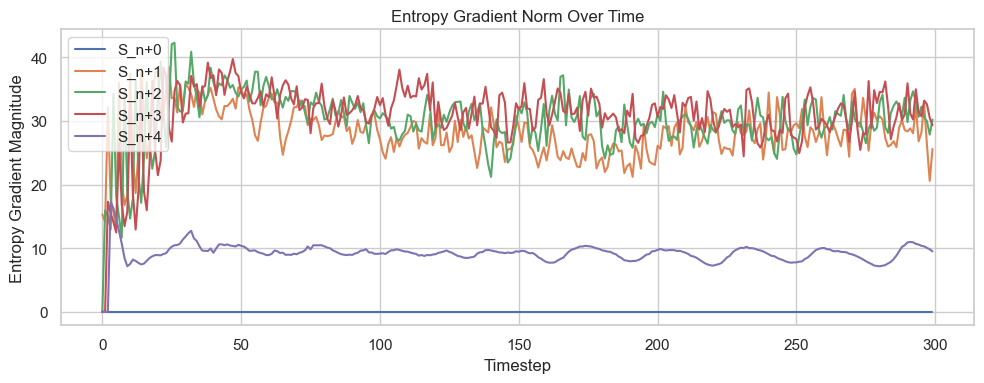

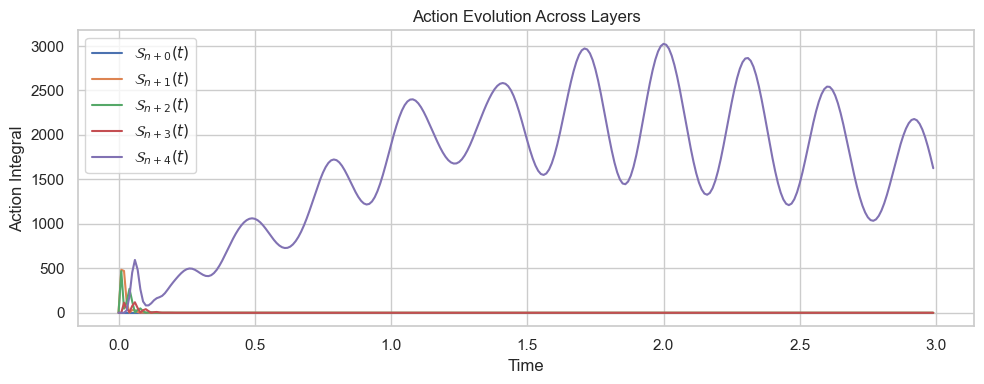

=== Action Summary ===
       count         mean         std       min          25%          50%  \
S_n+0  300.0     0.000000    0.000000  0.000000     0.000000     0.000000   
S_n+1  300.0     3.863943   39.498914  0.000051     0.000098     0.000129   
S_n+2  300.0     3.880037   33.049705  0.000000     0.000191     0.000305   
S_n+3  300.0     1.783152   11.563943  0.000000     0.000520     0.000733   
S_n+4  300.0  1642.755182  759.630318  0.000000  1119.065399  1690.436842   

               75%          max  
S_n+0     0.000000     0.000000  
S_n+1     0.000200   483.705924  
S_n+2     0.000428   468.982417  
S_n+3     0.000957   118.478067  
S_n+4  2240.475066  3024.456259  

=== Collapse Summary ===
     count       mean        std       min        25%        50%        75%  \
0→1  300.0   0.000000   0.000000  0.000000   0.000000   0.000000   0.000000   
1→2  300.0  24.288273  40.582408  6.994501   8.316594   9.873392  14.760499   
2→3  300.0  36.197777  43.919384  0.000000  17.

In [51]:
# alternate C.5 (this is not included in the preprint, strictly speaking, but gives visual intuition)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  CONFIGURATION 
x = np.linspace(0, 10, 200)
dx = x[1] - x[0]
dt = 0.01
time_steps = 300
num_layers = 5

alpha, beta, gamma = 0.6, 0.3, 0.1
collapse_gain = 5.0
decay_rate = 0.01

#  FIELD INITIALIZATION 
fields = [
    np.zeros_like(x) if i != 1 else np.exp(-0.5 * (x - 5)**2) + 0.1 * np.random.randn(len(x))
    for i in range(num_layers)
]
fields_prev = [f.copy() for f in fields]
fields_next = [np.zeros_like(x) for _ in range(num_layers)]

fields_history = [[] for _ in range(num_layers)]
action_history = [[] for _ in range(num_layers)]
collapse_events = [[] for _ in range(num_layers - 1)]

#  SIMULATION LOOP 
for t in range(time_steps):
    for i in range(num_layers):
        d2S_dx2 = np.gradient(np.gradient(fields[i], dx), dx)
        fields_next[i] = (2 * fields[i] - fields_prev[i] +
                          (dt ** 2 / gamma) * (alpha * d2S_dx2 - beta * fields[i]))
        fields_next[i] *= (1 - decay_rate)

    for i in range(num_layers - 1):
        grad_x = np.gradient(fields[i], dx)
        dS_dt = (fields[i] - fields_prev[i]) / dt
        curvature = alpha * np.gradient(grad_x, dx) + beta * fields[i] - gamma * np.gradient(dS_dt, dx)
        collapse_energy = np.tanh(collapse_gain * np.abs(curvature))

        fields_next[i + 1] += collapse_energy * fields[i] * 0.5
        fields_next[i] *= (1 - collapse_energy * 0.5)
        collapse_events[i].append(np.sum(collapse_energy))

    for i in range(num_layers):
        grad_x = np.gradient(fields[i], dx)
        dS_dt = (fields[i] - fields_prev[i]) / dt if t > 0 else np.zeros_like(fields[i])
        lagrangian = alpha * grad_x**2 - beta * fields[i]**2 + gamma * dS_dt**2
        action = np.sum(lagrangian) * dx
        action_history[i].append(action)
        fields_history[i].append(fields[i].copy())

        fields_prev[i] = fields[i].copy()
        fields[i] = fields_next[i].copy()

#  ENTROPY GRADIENTS 
def compute_entropy_gradients(fields_history, dx):
    entropy_history = []
    entropy_gradients = []

    for layer in fields_history:
        layer_entropy = []
        layer_grad = []

        for field in layer:
            p = np.abs(field)
            p /= np.sum(p) + 1e-12
            entropy_density = -p * np.log(p + 1e-12)
            entropy = np.sum(entropy_density) * dx
            grad_entropy = np.gradient(entropy_density, dx)

            layer_entropy.append(entropy)
            layer_grad.append(np.sum(np.abs(grad_entropy)))

        entropy_history.append(layer_entropy)
        entropy_gradients.append(layer_grad)

    return entropy_history, entropy_gradients

entropy_history, entropy_gradients = compute_entropy_gradients(fields_history, dx)
#  PLOTTING FIELD DYNAMICS 
fig, axs = plt.subplots(num_layers + 1, 1, figsize=(12, 3 * (num_layers + 1)), sharex=True)
for i in range(num_layers):
    mat = np.array(fields_history[i])
    im = axs[i].imshow(mat, aspect='auto', extent=[x[0], x[-1], time_steps * dt, 0], cmap='viridis')
    axs[i].set_title(f"Layer {i+1}: $S_{{n+{i}}}(x, t)$")
    axs[i].set_ylabel("Time")
    fig.colorbar(im, ax=axs[i], label="Field Magnitude")

axs[-1].set_title("Collapse Energy Transfer Over Time")
for i, events in enumerate(collapse_events):
    axs[-1].plot(np.arange(len(events)) * dt, events, label=f"Layer {i} → {i+1}")
axs[-1].set_xlabel("Time")
axs[-1].set_ylabel("Projected Curvature")
axs[-1].legend()
axs[-1].grid(True)
plt.tight_layout()
plt.show()


#  PLOTS: ENTROPY 
plt.figure(figsize=(10, 4))
for i, entropy_trace in enumerate(entropy_history):
    plt.plot(entropy_trace, label=f"S_n+{i}")
plt.title("Total Shannon Entropy Over Time")
plt.xlabel("Timestep")
plt.ylabel("Entropy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for i, grad_trace in enumerate(entropy_gradients):
    plt.plot(grad_trace, label=f"S_n+{i}")
plt.title("Entropy Gradient Norm Over Time")
plt.xlabel("Timestep")
plt.ylabel("Entropy Gradient Magnitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  PLOT: ACTION OVER TIME 
plt.figure(figsize=(10, 4))
for i in range(num_layers):
    plt.plot(np.arange(len(action_history[i])) * dt, action_history[i], label=f'$\\mathcal{{S}}_{{n+{i}}}(t)$')
plt.title("Action Evolution Across Layers")
plt.xlabel("Time")
plt.ylabel("Action Integral")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#  SUMMARY TABLES 
action_df = pd.DataFrame({f"S_n+{i}": action_history[i] for i in range(num_layers)})
collapse_df = pd.DataFrame({f"{i}→{i+1}": collapse_events[i] for i in range(num_layers - 1)})
entropy_df = pd.DataFrame({f"S_n+{i}": entropy_history[i] for i in range(num_layers)})
entropy_grad_df = pd.DataFrame({f"S_n+{i}": entropy_gradients[i] for i in range(num_layers)})

print("=== Action Summary ===")
print(action_df.describe().T)

print("\n=== Collapse Summary ===")
print(collapse_df.describe().T)

print("\n=== Entropy Summary ===")
print(entropy_df.describe().T)

print("\n=== Entropy Gradient Summary ===")
print(entropy_grad_df.describe().T)
